In [ ]:
import pennylane as qml
import jax
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import X, Z

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

import optax

from unicirc import compile_adapt, count_clifford

In [2]:
n=3
H = (X(0) @ X(1) + X(1) @ X(2) + Z(0) + Z(1) + Z(2))
ts = np.linspace(0.5, 10., 10)
Us = np.array([qml.matrix(qml.exp(-1j * t * H), wire_order=range(n)) for t in ts], dtype=complex)

In [ ]:
n_epochs = 10_000
n_thetas = 4**n - 1
adapt_tol = 1e-13
tol = 1e-15 # early-stops optimization
lr = None
seed = 0


optimizer = optax.lbfgs(learning_rate=lr, memory_size=100)

for jjj, U in enumerate(Us):
    print(f"Compiling unitary {jjj+1} / {len(Us)}\n")
    energies, thetas, num_cz = compile_adapt(U,
        "SU",
        optimizer,
        n_epochs,
        num_czs=range(3, 15),
        max_attempts_per_num_cz=20,
        tol=tol,
        adapt_tol=adapt_tol,
        max_const=500,
        progress_bar=False,
        num_records=500,
        seed=seed,)
    
    cliffs, non_cliffs, zeros = count_clifford(thetas[-1])
    print(f"Cliffs: {cliffs}, Non-Cliffords: {non_cliffs}, Zeros: {zeros}")

    results_name = f"data/adapt-Ising-Fig-7_results_n-{n}_epochs-{n_epochs}_thetas-{n_thetas}_seed-{seed}_{jjj}"
    results = {"energy": energies, "thetas": thetas, "num_cz": num_cz}
    print(f"saving under {results_name}")
    np.savez(results_name + ".npz", **results)

Compiling unitary 1 / 10

Trying with num_cz=3 / 14
Trying with num_cz=4 / 14
Trying with num_cz=5 / 14
Trying with num_cz=6 / 14
Cliffs: 12, Non-Cliffords: 15, Zeros: 6
saving under adapt-Ising-Fig-7_results_n-3_epochs-10000_thetas-63_seed-0_0
Compiling unitary 2 / 10

Trying with num_cz=3 / 14
Trying with num_cz=4 / 14
Trying with num_cz=5 / 14
Trying with num_cz=6 / 14
Cliffs: 12, Non-Cliffords: 15, Zeros: 6
saving under adapt-Ising-Fig-7_results_n-3_epochs-10000_thetas-63_seed-0_1
Compiling unitary 3 / 10

Trying with num_cz=3 / 14
Trying with num_cz=4 / 14
Trying with num_cz=5 / 14
Trying with num_cz=6 / 14
Cliffs: 14, Non-Cliffords: 13, Zeros: 6
saving under adapt-Ising-Fig-7_results_n-3_epochs-10000_thetas-63_seed-0_2
Compiling unitary 4 / 10

Trying with num_cz=3 / 14
Trying with num_cz=4 / 14
Trying with num_cz=5 / 14
Trying with num_cz=6 / 14
Cliffs: 12, Non-Cliffords: 15, Zeros: 6
saving under adapt-Ising-Fig-7_results_n-3_epochs-10000_thetas-63_seed-0_3
Compiling unitary 5 

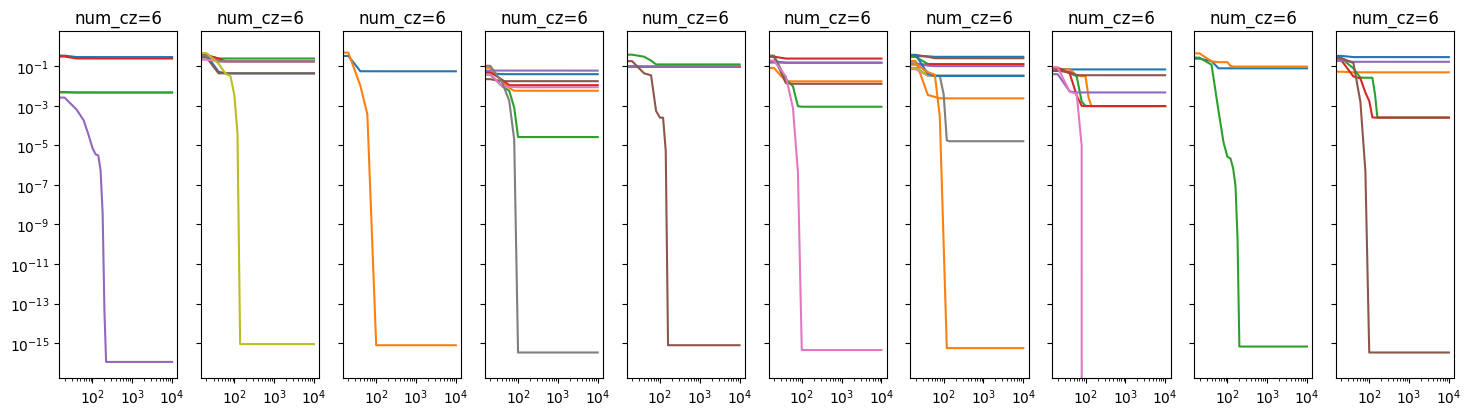

In [ ]:
fig, axs = plt.subplots(ncols=10, nrows=1, figsize=(18, 4.5), sharey="row", sharex=True, squeeze=False)

for jjj in range(len(ts)):
    dat = np.load(f'data/adapt-Ising-Fig-7_results_n-3_epochs-10000_thetas-63_seed-0_{jjj}.npz', allow_pickle=True)
    energies = dat["energy"]
    num_cz = dat["num_cz"].item()
    theta = dat["thetas"]
    ax = axs[jjj//10, jjj % 10]
    for e in energies:
        ax.plot(e[:, 0], e[:, 1])
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title(f"{num_cz=}")

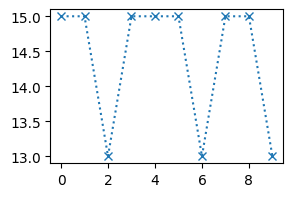

In [ ]:
non_cliffss = []
for jjj in range(len(ts)):
    dat = np.load(f'data/adapt-Ising-Fig-7_results_n-3_epochs-10000_thetas-63_seed-0_{jjj}.npz', allow_pickle=True)
    thetas = dat["thetas"][-1]
    cliffs, non_cliffs, zeros = count_clifford(thetas)
    non_cliffss.append(non_cliffs)

mean = np.mean(non_cliffss)
std = np.std(non_cliffss)

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(non_cliffss, "x:")
# ax.hlines(63, 0, 18, color="k")
# ax.hlines(mean, 0, 18, color="k", linestyles="dotted")
# ax.set_xlabel("# unitary")
# ax.set_ylabel("# non-clifford angles")
# ax.set_title(f"anthracene adapt; avg: {mean:.0f} $\\pm$ {std:.0f}")

In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
# plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

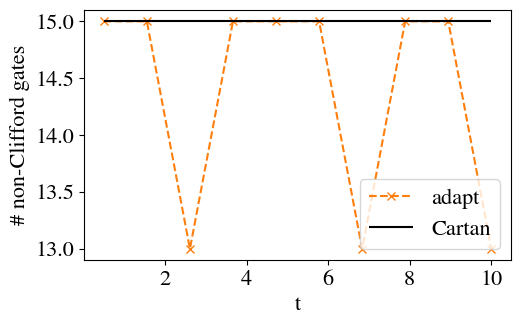

In [7]:
fig, ax = plt.subplots(figsize=(5.5, 3.25))
ax.plot(ts, non_cliffss, "x--", label="adapt", color="tab:orange")
ax.hlines(15, 0.5, 10, label="Cartan", color="k")
ax.set_ylabel("# non-Clifford gates")
ax.set_xlabel("t")
ax.legend(loc=4)
plt.tight_layout
plt.savefig("adapt-Ising.pdf", bbox_inches = 'tight', dpi=300)